In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
# i prefer PIL to draw the text, more beautiful
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

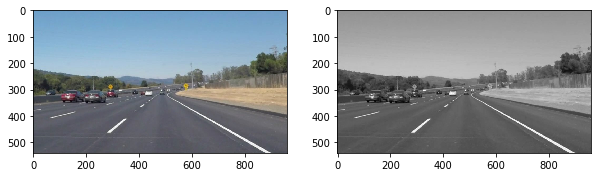

In [2]:
image = cv2.imread('test_images/solidWhiteCurve.jpg')
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),cmap='gray')
plt.show()

In [3]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
         
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color = [255, 0, 0], thickness = 2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    # img is the output of the canny()
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength = min_line_len, maxLineGap = max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return lines, line_img

def weighted_img(img, initial_img, alpha = 0.8, beta = 1., gamma = 0.):
    # img is the output of the hough_lines(), An image with lines drawn on it.
    # initial_img should be the image before any processing.
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

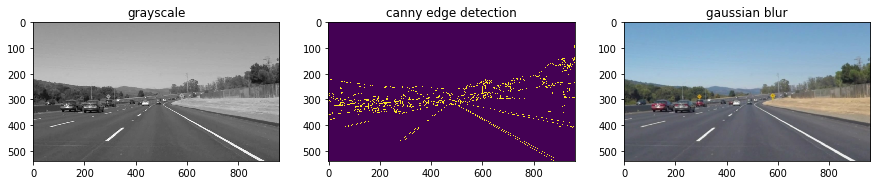

In [4]:
plt.figure(figsize = (15, 15))

plt.subplot(1, 3, 1)
plt.imshow(grayscale(image), cmap = 'gray')
plt.title('grayscale')

plt.subplot(1, 3, 2)
plt.imshow(canny(image, 50, 150))
plt.title('canny edge detection')

plt.subplot(1, 3, 3)
plt.imshow(gaussian_blur(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 5))
plt.title('gaussian blur')

plt.show()

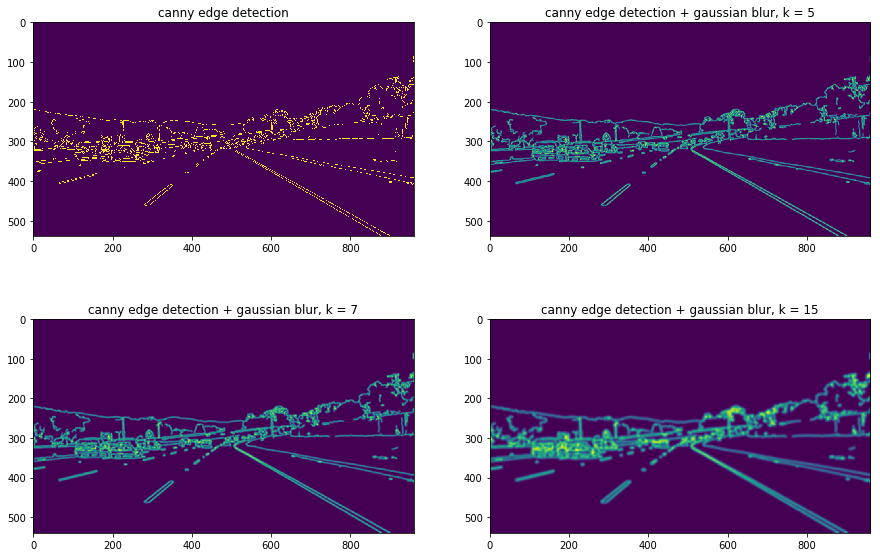

In [5]:
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.imshow(canny(image, 50, 150))
plt.title('canny edge detection')

plt.subplot(2, 2, 2)
plt.imshow(gaussian_blur(canny(image, 50, 150),5))
plt.title('canny edge detection + gaussian blur, k = 5')

plt.subplot(2, 2, 3)
plt.imshow(gaussian_blur(canny(image, 50, 150),7))
plt.title('canny edge detection + gaussian blur, k = 7')

plt.subplot(2, 2, 4)
plt.imshow(gaussian_blur(canny(image, 50, 150),15))
plt.title('canny edge detection + gaussian blur, k = 15')
plt.show()

In [6]:
rows, cols   = image.shape[:2]
bottom_left  = [int(cols*0.02), int(rows*1)]
top_left     = [int(cols*0.35), int(rows*0.65)]
bottom_right = [int(cols*0.98), int(rows*1)]
top_right    = [int(cols*0.65), int(rows*0.65)]

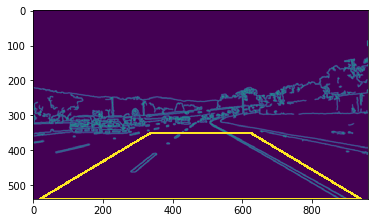

In [7]:
gaussian_7 = gaussian_blur(canny(image, 50, 150),7)
copied = np.copy(gaussian_7)
cv2.line(copied, tuple(bottom_left), tuple(bottom_right), (255,0,0), 5)
cv2.line(copied, tuple(bottom_left), tuple(top_left), (255,0,0), 5)
cv2.line(copied, tuple(top_left), tuple(top_right), (255,0,0), 5)
cv2.line(copied, tuple(top_right), tuple(bottom_right), (255,0,0), 5)
plt.imshow(copied)
plt.show()

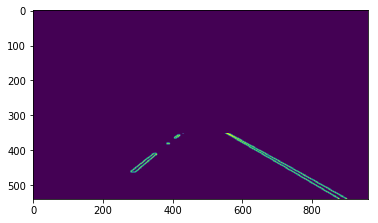

In [8]:
copied = np.copy(gaussian_7)
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
interested = region_of_interest(copied, vertices)
plt.imshow(interested)
plt.show()

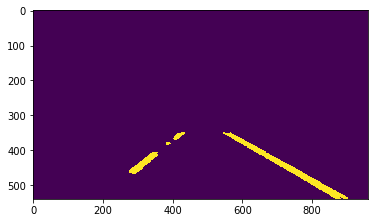

In [9]:
copied = np.copy(gaussian_7)
rho = 1
theta = np.pi / 180 
threshold = 5
min_line_length = 10 
max_line_gap = 8
interested = region_of_interest(copied, vertices)
lines,image_lines = hough_lines(interested, rho, theta,threshold,min_line_length,max_line_gap)
plt.imshow(image_lines)
plt.show()

In [10]:
right_sides = {'x':[],'y':[]}
left_sides = {'x':[],'y':[]}
half = image.shape[1]//2
for lane in lines:
    for x1,y1,x2,y2 in lane:
        if x1 < half:
            left_sides['x'].append(x2)
            left_sides['y'].append(y2)
        else:
            right_sides['x'].append(x1)
            right_sides['y'].append(y1)

In [11]:
a_right, b_right = np.polyfit([np.min(right_sides['y']),np.max(right_sides['y'])],
                  [np.min(right_sides['x']),np.max(right_sides['x'])],1)
print(a_right, b_right)
BottomRightX = int(image.shape[0]*a_right+b_right)

a_left, b_left = np.polyfit([np.max(left_sides['y']),np.min(left_sides['y'])],
                  [np.min(left_sides['x']),np.max(left_sides['x'])],1)
print(a_left, b_left)
BottomLeftX = int(image.shape[0]*a_left+b_left)

1.7231638418079094 -59.83050847457606
-1.2894736842105246 886.6052631578941


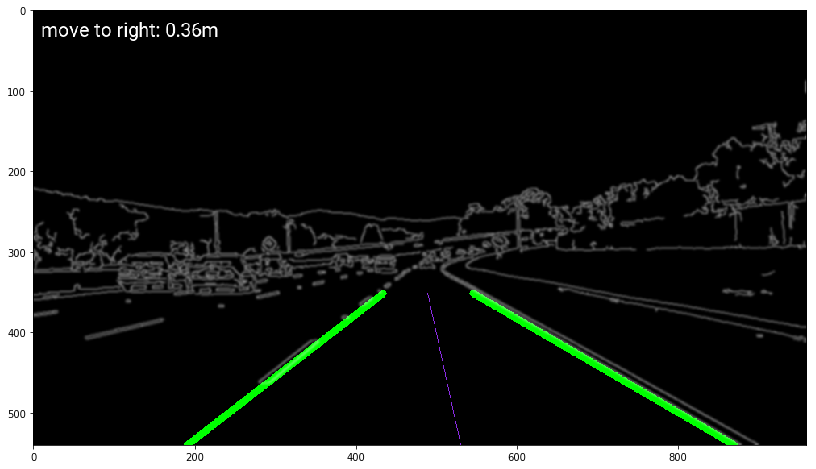

In [12]:
plt.figure(figsize=(15,8))
copied = np.copy(image) * 0
color_edges = np.dstack((gaussian_7, gaussian_7, gaussian_7))

TopRightX = np.min(right_sides['x'])
TopRightY = np.min(right_sides['y'])
TopLeftX = np.max(left_sides['x'])
TopLeftY = np.min(left_sides['y'])
if TopRightY < TopLeftY:
    TopLeftY = TopRightY
else:
    TopRightY = TopLeftY

cv2.line(copied,(TopLeftX, TopLeftY),(BottomLeftX, image.shape[0]), (0, 255, 0), 8)
cv2.line(copied,(TopRightX, TopRightY),(BottomRightX, image.shape[0]), (0, 255, 0), 8)

top = (TopLeftX + int((TopRightX - TopLeftX) / 2), TopLeftY)
bottom = (BottomLeftX + int((BottomRightX-BottomLeftX)/2), image.shape[0])
cv2.line(copied,top,bottom, (138,43,226), 1)

ratio_road = int((image.shape[1]-(BottomRightX-BottomLeftX))/2)
steering = (BottomLeftX / ratio_road) - 1

if steering < 0:
    string_steering = 'move to left: %.2fm'%(steering)
else:
    string_steering = 'move to right: %.2fm'%(steering)
    
copied = cv2.addWeighted(color_edges, 0.8, copied, 1, 0)
    
pil_image = Image.fromarray(np.uint8(copied))
draw = ImageDraw.Draw(pil_image)
font = ImageFont.truetype('Roboto-Regular.ttf', 24)
draw.text((10, 10),string_steering,fill='white',font=font)

plt.imshow(np.array(pil_image))

plt.show()

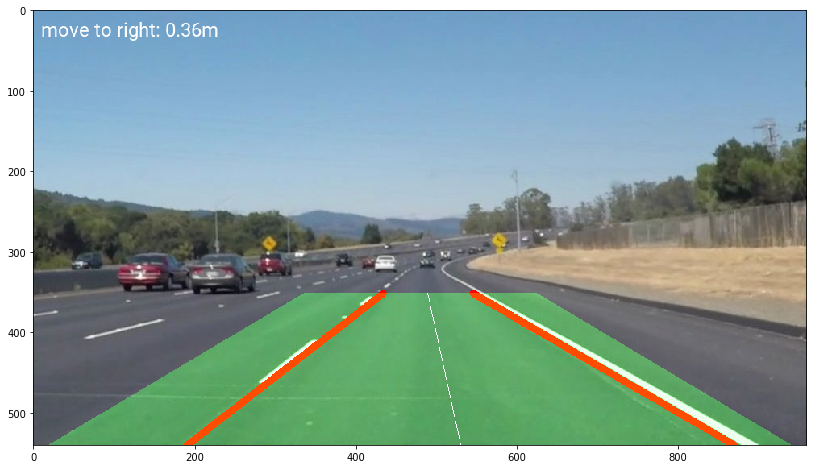

In [13]:
plt.figure(figsize=(15,8))
copied = np.copy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
cv2.line(copied,(TopLeftX, TopLeftY),(BottomLeftX, image.shape[0]), (255, 0, 0), 8)
cv2.line(copied,(TopRightX, TopRightY),(BottomRightX, image.shape[0]), (255, 0, 0), 8)

top = (TopLeftX + int((TopRightX - TopLeftX) / 2), TopLeftY)
bottom = (BottomLeftX + int((BottomRightX-BottomLeftX)/2), image.shape[0])
cv2.line(copied,top,bottom, (255,255,255), 1)

ratio_road = int((image.shape[1]-(BottomRightX-BottomLeftX))/2)
steering = (BottomLeftX / ratio_road) - 1

if steering < 0:
    string_steering = 'move to left: %.2fm'%(steering)
else:
    string_steering = 'move to right: %.2fm'%(steering)
    
window_img = np.zeros_like(copied)
    
polyfill = np.array([bottom_left,bottom_right,top_right,top_left])
cv2.fillPoly(window_img, pts =[polyfill], color=(0,255, 0))
copied = cv2.addWeighted(copied, 1, window_img, 0.3, 0)
    
pil_image = Image.fromarray(np.uint8(copied))
draw = ImageDraw.Draw(pil_image)
font = ImageFont.truetype('Roboto-Regular.ttf', 24)
draw.text((10, 10),string_steering,fill='white',font=font)

plt.imshow(np.array(pil_image))

plt.show()

In [14]:
from moviepy.editor import VideoFileClip

In [15]:
previous_a_right, previous_b_right = 0, 0
previous_a_left, previous_b_left = 0, 0

In [20]:
def process_image(image):
    global previous_a_right, previous_b_right, previous_a_left, previous_b_left
    gray = grayscale(image)
    low_threshold = 100
    high_threshold = 150
    edges = canny(gray, low_threshold, high_threshold)
    kernel_size = 7
    blur_gray = gaussian_blur(edges,kernel_size)
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255
    rows, cols   = image.shape[:2]
    smoothing = 0.95
    bottom_left  = [int(cols*0.02), int(rows*1)]
    top_left     = [int(cols*0.35), int(rows*0.65)]
    bottom_right = [int(cols*0.98), int(rows*1)]
    top_right    = [int(cols*0.65), int(rows*0.65)]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    interested = region_of_interest(edges, vertices)
    rho = 1
    theta = np.pi / 90 
    threshold = 10
    min_line_length = 10
    max_line_gap = 8
    lines = cv2.HoughLinesP(interested, rho, theta, threshold, np.array([]), 
                            minLineLength = min_line_length, maxLineGap = max_line_gap)
    #return image_lines
    right_sides = {'x':[],'y':[]}
    left_sides = {'x':[],'y':[]}
    half = image.shape[1]//2
    
    interested_stack = np.stack((interested,)*3, -1)
    
    for lane in lines:
        for x1,y1,x2,y2 in lane:
            if x1 < half:
                left_sides['x'].append(x2)
                left_sides['y'].append(y2)
                interested = cv2.circle(interested_stack,(x2,y2),5,(255, 0, 0), 3)
            else:
                right_sides['x'].append(x1)
                right_sides['y'].append(y1)
                interested = cv2.circle(interested_stack,(x1,y1),5,(255, 0, 0), 3)
    
    a_right, b_right = np.polyfit([np.min(right_sides['y']),np.max(right_sides['y'])],
                  [np.min(right_sides['x']),np.max(right_sides['x'])],1)

    a_left, b_left = np.polyfit([np.max(left_sides['y']),np.min(left_sides['y'])],
                  [np.min(left_sides['x']),np.max(left_sides['x'])],1)
    
    if previous_a_right == 0 and previous_b_right == 0:
        previous_a_right = a_right
        previous_b_right = b_right
    else:
        # last * weight + (1 - weight) * point
        a_right = previous_a_right * smoothing + (1 - smoothing) * a_right
        previous_a_right = a_right
        b_right = previous_b_right * smoothing + (1 - smoothing) * b_right
        previous_b_right = b_right
        
    if previous_a_left == 0 and previous_b_left == 0:
        previous_a_left = a_left
        previous_b_left = b_left
    else:
        # last * weight + (1 - weight) * point
        a_left = previous_a_left * smoothing + (1 - smoothing) * a_left
        previous_a_left = a_left
        b_left = previous_b_left * smoothing + (1 - smoothing) * b_left
        previous_b_left = b_left
    
    BottomRightX = int(image.shape[0]*a_right+b_right)
    BottomLeftX = int(image.shape[0]*a_left+b_left)
    
    TopRightX = np.min(right_sides['x'])
    TopRightY = np.min(right_sides['y'])
    TopLeftX = np.max(left_sides['x'])
    TopLeftY = np.min(left_sides['y'])
    
    if TopRightY < TopLeftY:
        TopLeftY = TopRightY
        TopLeftX = int(TopLeftY*a_left+b_left)
    else:
        TopRightY = TopLeftY
        TopRightX = int(TopRightY*a_right+b_right)
        
    cv2.line(image,(TopLeftX, TopLeftY),(BottomLeftX, image.shape[0]), (255, 0, 0), 8)
    cv2.line(image,(TopRightX, TopRightY),(BottomRightX, image.shape[0]), (255, 0, 0), 8)

    top = (TopLeftX + int((TopRightX - TopLeftX) / 2), TopLeftY)
    bottom = (BottomLeftX + int((BottomRightX-BottomLeftX)/2), image.shape[0])
    cv2.line(image,top,bottom, (255,255,255), 1)

    ratio_road = int((image.shape[1]-(BottomRightX-BottomLeftX))/2)
    steering = (BottomLeftX / ratio_road) - 1

    if steering < 0:
        string_steering = 'move to left: %.2fm'%(steering)
    else:
        string_steering = 'move to right: %.2fm'%(steering)
        
    window_img = np.zeros_like(image)
    
    polyfill = np.array([bottom_left,bottom_right,top_right,top_left])
    cv2.fillPoly(window_img, pts =[polyfill], color=(0,255, 0))
    image = cv2.addWeighted(image, 1, window_img, 0.3, 0)
    
    pil_image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.truetype('Roboto-Regular.ttf', 24)
    draw.text((10, 10),string_steering,fill='white',font=font)
    return np.concatenate([np.array(pil_image),interested_stack],axis=1)

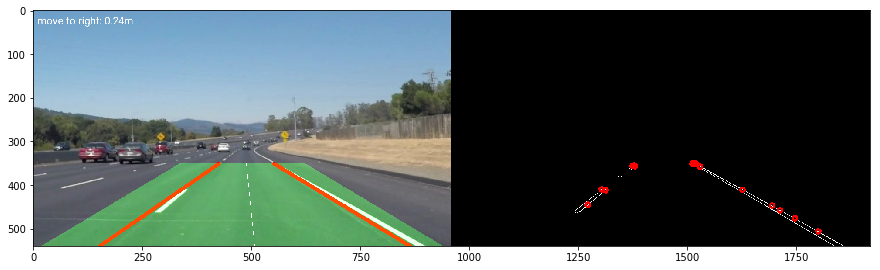

In [21]:
plt.figure(figsize=(15,8))
cp_image = np.copy(image)
plt.imshow(process_image(cv2.cvtColor(cp_image, cv2.COLOR_BGR2RGB)))
plt.show()

In [22]:
white_output = 'testwhite_both.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio = False)

[MoviePy] >>>> Building video testwhite_both.mp4
[MoviePy] Writing video testwhite_both.mp4


100%|█████████▉| 221/222 [00:03<00:00, 62.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: testwhite_both.mp4 

CPU times: user 5.79 s, sys: 1.48 s, total: 7.27 s
Wall time: 3.92 s


In [23]:
yellow_output = 'testyellow_both.mp4'
clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")

yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio = False)

[MoviePy] >>>> Building video testyellow_both.mp4
[MoviePy] Writing video testyellow_both.mp4


100%|█████████▉| 681/682 [00:12<00:00, 55.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: testyellow_both.mp4 

CPU times: user 19 s, sys: 4.77 s, total: 23.8 s
Wall time: 12.6 s
